In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import TensorDataset, DataLoader

In [18]:
# Load the data
df = pd.read_csv('./mimic_ed_clean_combined.csv')

In [19]:
#def vital_flag(x, low, high):
#    normal = x.between(low,high,inclusive='both')
#    return(np.where(normal,0,1))
#
#normal_ranges = {
#    "sbp": (90, 120),
#    "dbp": (60, 80),
#    "heartrate": (60, 100),
#    "resprate": (12, 20),
#    "temperature": (97, 99),
#    "o2sat": (95, 100),
#    "acuity": (3,5),
#    "pain": (0,3)
#}
#
#for vital, (low, high) in normal_ranges.items():
#    df[vital] = vital_flag(df[vital], low, high)

In [20]:
# w/ CC
X = df[['acuity','dbp','heartrate','o2sat','pain','resprate','sbp','temperature',
       'cc_abd','cc_chest','cc_dyspnea','cc_fall','cc_pain','cc_transfer','cc_weakness']].values
y = df['los'].values
y = np.log10(y+1) # Log transformation

In [21]:
# w/o CC
X = df[['acuity','dbp','heartrate','o2sat','pain','resprate','sbp','temperature']].values
y = df['los'].values
y = np.log10(y+1) # Log transformation

In [12]:
# Split training and testing sets 75/25
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=123456) # 12345678

In [105]:
# Model 1 - Lasso
# Hypeparameter search
a_grid = np.logspace(-4,1,50) # 50 values from 0.0001 to 100
max_iter = 1000
seed = 123

loo = LeaveOneOut()
#loo = KFold(n_splits=4,shuffle=True,random_state=seed)

cv_tr_mse_list = []
cv_val_mse_list = []

# Round 1: choose the optimal alphas by LOOCV
for a in a_grid:
    errors1 = []
    errors2 = []
    for train_idx, val_idx in loo.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Can be an issue if we're binarizing the vitals
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)
        #X_tr_scaled = X_tr
        #X_val_scaled = X_val
        
        mdl = Lasso(alpha=a, max_iter=max_iter, random_state=seed)
        mdl.fit(X_tr_scaled,y_tr)

        y_tr_pred = mdl.predict(X_tr_scaled)
        error1 = mean_squared_error(y_tr,y_tr_pred)
        errors1.append(error1)
        
        y_val_pred = mdl.predict(X_val_scaled)
        error2 = mean_squared_error(y_val,y_val_pred)
        errors2.append(error2)

    cv_mse1 = np.mean(errors1)
    cv_mse2 = np.mean(errors2)
    cv_tr_mse_list.append(cv_mse1)
    cv_val_mse_list.append(cv_mse2)
    print(f"alpha={a:.5f}, training MSE={cv_mse1:.5f}, validation MSE={cv_mse2:.5f};")

a_opt = a_grid[np.argmin(np.array(cv_val_mse_list))]
print(f'\nThe best alpha is {a_opt:.5f}.')

# Round 2: run the whole traning data with optimal alpha
scaler2 = StandardScaler()
X_train_scaled = scaler2.fit_transform(X_train)
X_test_scaled = scaler2.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

mdl2 = Lasso(alpha=a_opt,max_iter=max_iter,random_state=seed)
mdl2.fit(X_train_scaled, y_train)

y_test_pred = mdl2.predict(X_test_scaled)

mse2 = mean_squared_error(y_test,y_test_pred)

alpha=0.00010, training MSE=0.06861, validation MSE=0.10784;
alpha=0.00013, training MSE=0.06861, validation MSE=0.10777;
alpha=0.00016, training MSE=0.06861, validation MSE=0.10768;
alpha=0.00020, training MSE=0.06861, validation MSE=0.10757;
alpha=0.00026, training MSE=0.06861, validation MSE=0.10742;
alpha=0.00032, training MSE=0.06861, validation MSE=0.10724;
alpha=0.00041, training MSE=0.06862, validation MSE=0.10702;
alpha=0.00052, training MSE=0.06862, validation MSE=0.10673;
alpha=0.00066, training MSE=0.06862, validation MSE=0.10638;
alpha=0.00083, training MSE=0.06862, validation MSE=0.10595;
alpha=0.00105, training MSE=0.06862, validation MSE=0.10541;
alpha=0.00133, training MSE=0.06863, validation MSE=0.10472;
alpha=0.00168, training MSE=0.06863, validation MSE=0.10387;
alpha=0.00212, training MSE=0.06865, validation MSE=0.10282;
alpha=0.00268, training MSE=0.06867, validation MSE=0.10151;
alpha=0.00339, training MSE=0.06870, validation MSE=0.09989;
alpha=0.00429, training 

In [106]:
cv_val_mse_list1 = cv_val_mse_list
cv_tr_mse_list2 = cv_tr_mse_list

<Figure size 100x100 with 0 Axes>

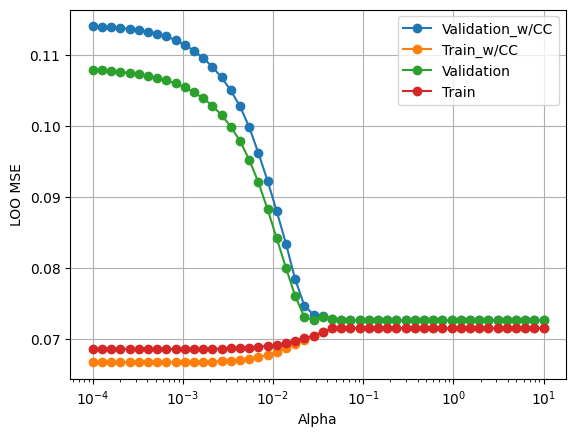

In [88]:
plt.figure(figsize=(1,1)) 
plt.figure()
plt.plot(a_grid, np.array(cv_val_mse_list1),label='Validation_w/CC',marker='o')
plt.plot(a_grid, np.array(cv_tr_mse_list2),label='Train_w/CC',marker='o')
plt.plot(a_grid, np.array(cv_val_mse_list),label='Validation',marker='o')
plt.plot(a_grid, np.array(cv_tr_mse_list),label='Train',marker='o')
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("LOO MSE")
plt.grid()
plt.legend()
#plt.show()

plt.savefig("lasso.pdf", format="pdf", bbox_inches="tight")

In [22]:
#mdl2.intercept_
#mdl2.coef_
#mse2

In [13]:
# Model 2 - MLP
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# Build MLP
class MLPRegressor(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 8),
            nn.ReLU(),
            nn.Linear(8,4),
            nn.ReLU(),
            nn.Linear(4,1)
        )

    def forward(self, x):
        return self.net(x)

n_features = X_train_t.shape[1]
mdl = MLPRegressor(n_features)

# Upload data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdl = mdl.to(device)
X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

# Build DataLoader and optimizer
batch_size = 8
train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_ds = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mdl.parameters(), lr=1e-4, weight_decay=1e-4) # L2 regularization

# Training
n_epochs = 5000
early_stop_delta = 1e-8  # threshold for little change in training MSE
train_loss_list = []
test_loss_list = []

for epoch in range(1, n_epochs+1):

    mdl.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mdl(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_loss_list.append(epoch_loss)

    mdl.eval()
    with torch.no_grad():
        test_preds = []
        test_targets = []
        for xb, yb in test_loader:
            preds = mdl(xb)
            test_preds.append(preds.cpu().numpy())
            test_targets.append(yb.cpu().numpy())
        test_preds = np.vstack(test_preds).ravel()
        test_targets = np.vstack(test_targets).ravel()
        test_loss = mean_squared_error(test_targets, test_preds)
        test_loss_list.append(test_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}: train MSE={epoch_loss:.4f}, val MSE={test_loss:.4f}")

    if epoch > 1:
        delta = abs(train_loss_list[epoch-2] - train_loss_list[epoch-1])
        if delta < early_stop_delta:
            print(f"Early stop at epoch {epoch}: Δtrain MSE={delta:.4f} < {early_stop_delta}")
            break

Epoch   1: train MSE=13.5063, val MSE=13.8760
Epoch  10: train MSE=12.8067, val MSE=13.2138
Epoch  20: train MSE=11.9431, val MSE=12.3830
Epoch  30: train MSE=10.9945, val MSE=11.4781
Epoch  40: train MSE=9.9809, val MSE=10.4990
Epoch  50: train MSE=8.9446, val MSE=9.4884
Epoch  60: train MSE=7.8892, val MSE=8.4485
Epoch  70: train MSE=6.8378, val MSE=7.4080
Epoch  80: train MSE=5.8123, val MSE=6.3784
Epoch  90: train MSE=4.8366, val MSE=5.3827
Epoch 100: train MSE=3.9336, val MSE=4.4432
Epoch 110: train MSE=3.1316, val MSE=3.5801
Epoch 120: train MSE=2.4439, val MSE=2.8302
Epoch 130: train MSE=1.8793, val MSE=2.1927
Epoch 140: train MSE=1.4240, val MSE=1.6621
Epoch 150: train MSE=1.0870, val MSE=1.2663
Epoch 160: train MSE=0.8365, val MSE=0.9660
Epoch 170: train MSE=0.6615, val MSE=0.7603
Epoch 180: train MSE=0.5438, val MSE=0.6236
Epoch 190: train MSE=0.4620, val MSE=0.5346
Epoch 200: train MSE=0.4032, val MSE=0.4726
Epoch 210: train MSE=0.3572, val MSE=0.4331
Epoch 220: train MSE=0.

<Figure size 100x100 with 0 Axes>

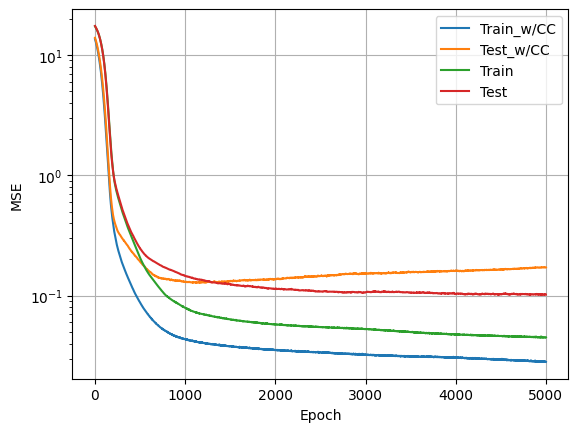

In [146]:
plt.figure(figsize=(1,1)) 

plt.figure()
plt.plot(range(1,epoch+1), np.array(train_loss_list)[0:],label='Train_w/CC')
plt.plot(range(1,epoch+1), np.array(test_loss_list)[0:],label='Test_w/CC')
plt.plot(range(1,epoch+1), np.array(train_loss_list1)[0:],label='Train')
plt.plot(range(1,epoch+1), np.array(test_loss_list1)[0:],label='Test')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.legend()

plt.savefig("mlp.pdf", format="pdf", bbox_inches="tight")

In [23]:
train_loss_list1 = train_loss_list
test_loss_list1 = test_loss_list

In [24]:
#test_loss_list[np.argmin(test_loss_list)]
#np.argmin(test_loss_list)

In [25]:
# Test
mdl.eval()
with torch.no_grad():
    y_test_pred_t = mdl(X_test_t)
    y_test_pred = y_test_pred_t.cpu().numpy().ravel()
    y_test_np = y_test_t.cpu().numpy().ravel()

test_mse = mean_squared_error(y_test_np,y_test_pred)
print(f"\nTest MSE: {test_mse:.4f}")


Test MSE: 0.1716
